In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.preprocessing import MinMaxScaler
import joblib

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Wahre Werte der Testdaten
y_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung in endogene und exogene Daten
exog_train = df_scaled[["arbeitstag", "temperatur", "tagesstunden"]][:"2020-12-31"]
exog_test = df_scaled[["arbeitstag", "temperatur", "tagesstunden"]]["2021-01-01":]

exog = exog_train.append(exog_test)

endog_train = df_scaled["verbrauch"][:"2020-12-31"]
endog_test = df_scaled["verbrauch"]["2021-01-01":]

endog = endog_train.append(endog_test)

# <font size="7">Erweiterung mit exogenen Daten</font>

<font size="5">Das endogene ARIMA(2,0,2)(2,0,2)7 soll im nächsten Schritt durch exogene Daten erweitert werden.<font>

## <font size="6">auto_arima()</font>

<font size="5">Es wird zunächst noch einmal geprüft, ob die auto_arima()-Funktion auch unter Verwendung der exogenen Daten zum gleichen Ergebnis kommt. Die Funktion ermittelt ebenfalls ein AIRMA(2,0,2)(2,0,2)7.<font>

In [4]:
model = auto_arima(y=endog, x=exog, seasonal=True, m=7, d=0, D=0, information_criterion="aic", trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-5830.350, Time=4.56 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-705.558, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-4833.713, Time=1.77 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-3350.364, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4297.801, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-3440.116, Time=3.68 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-4797.181, Time=4.01 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=-5824.050, Time=6.96 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=-5777.461, Time=8.85 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-2210.906, Time=1.93 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=-3938.336, Time=6.90 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=-5236.242, Time=6.54 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=-5948.055, Time=10.14 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=8.42 sec
 ARIMA(2,0,1)(2,0,2)[7] in

## <font size="6">ARIMA(2,0,2)(2,0,2)7 [Arbeitstag]</font><a class="anchor" id="4-02b-arbeitstag"></a>

<font size="5">Das ARIMA-Modell wird durch den Indikator für Arbeitstage erweitert. Der MAPE fällt auf 2,25%, die Log-Likelihood steigt auf 4.342 an und das AIC fällt auf -8.665 ab Das Modell hat sich also im Vergleich zum endogenen Modell stark verbessert. Der Koeffizient für Arbeitstage ist signifikant.<font>

In [5]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train["arbeitstag"], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog["arbeitstag"], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4342.340
Date:                           Thu, 03 Feb 2022   AIC                          -8664.679
Time:                                   13:46:44   BIC                          -8606.213
Sample:                               01-01-2015   HQIC                         -8643.478
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2967      0.002    127.669      0.000       0.292       0.301
ar.L1          0.9924      0.122      8.117

      Vorhersage
R2          0.95
MAE       3835.0
MSE   31510313.0
RMSE      5613.0
                
MAPE      2.25 %


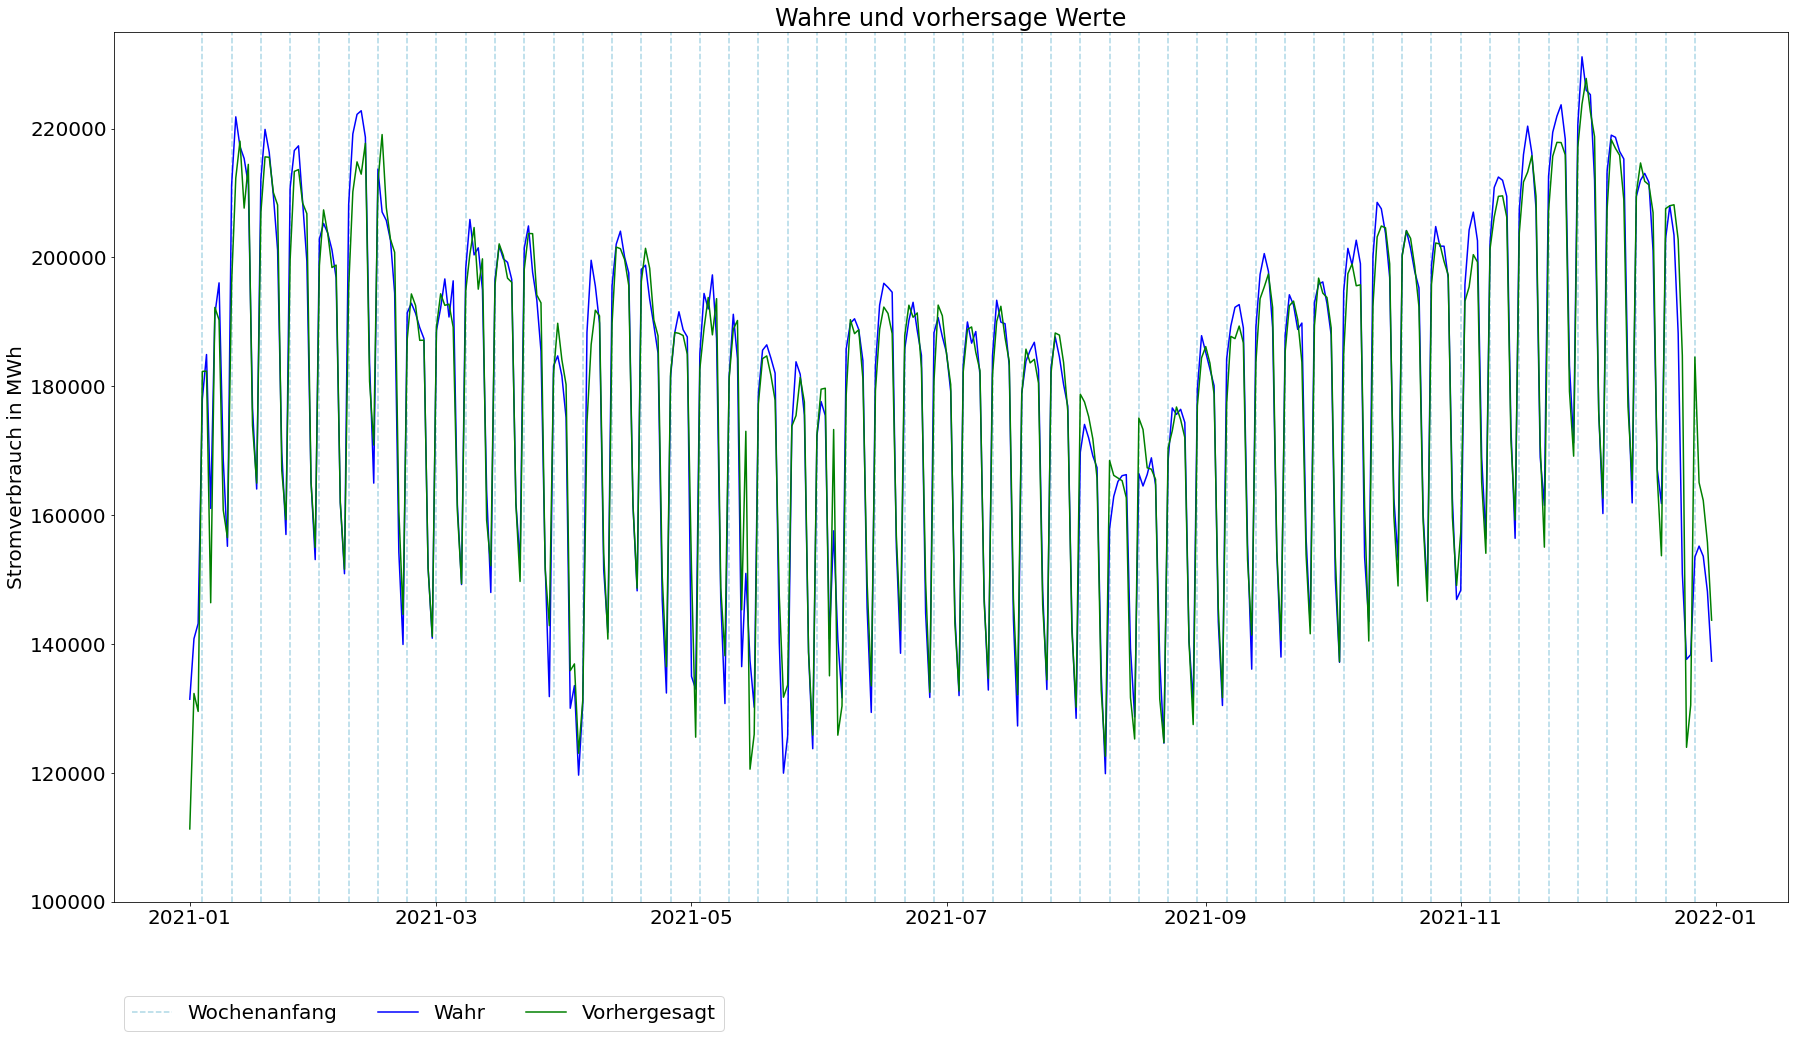

In [6]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds)

## <font size="6">ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur]</font><a class="anchor" id="4-02b-arbeitstagtemperatur"></a>

<font size="5">Durch Erweiterung um die Temperatur wird das Modell nur leicht verbessert. Der MAPE fällt weiter auf 2,23%, die Log-Likelihood verbessert sich auf 4.343 nur minimal, das AIC ist mit -8.684 etwas besser. Der Informationsgewinn durch die Temperatur ist also gering, aber durchaus relevant. Da das Modell die jährliche Saisonalität auch ohne die Temperatur abbilden kann, hat die Temperatur einen geringen Einfluss. Trotzdem wird der Koeffizient als signifikant erachtet.<font>

In [3]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4352.812
Date:                           Fri, 04 Feb 2022   AIC                          -8683.624
Time:                                   12:29:57   BIC                          -8619.312
Sample:                               01-01-2015   HQIC                         -8660.303
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2967      0.002    129.917      0.000       0.292       0.301
temperatur    -0.0575      0.014     -4.138

      Vorhersage
R2          0.96
MAE       3777.0
MSE   31046773.0
RMSE      5572.0
                
MAPE      2.22 %


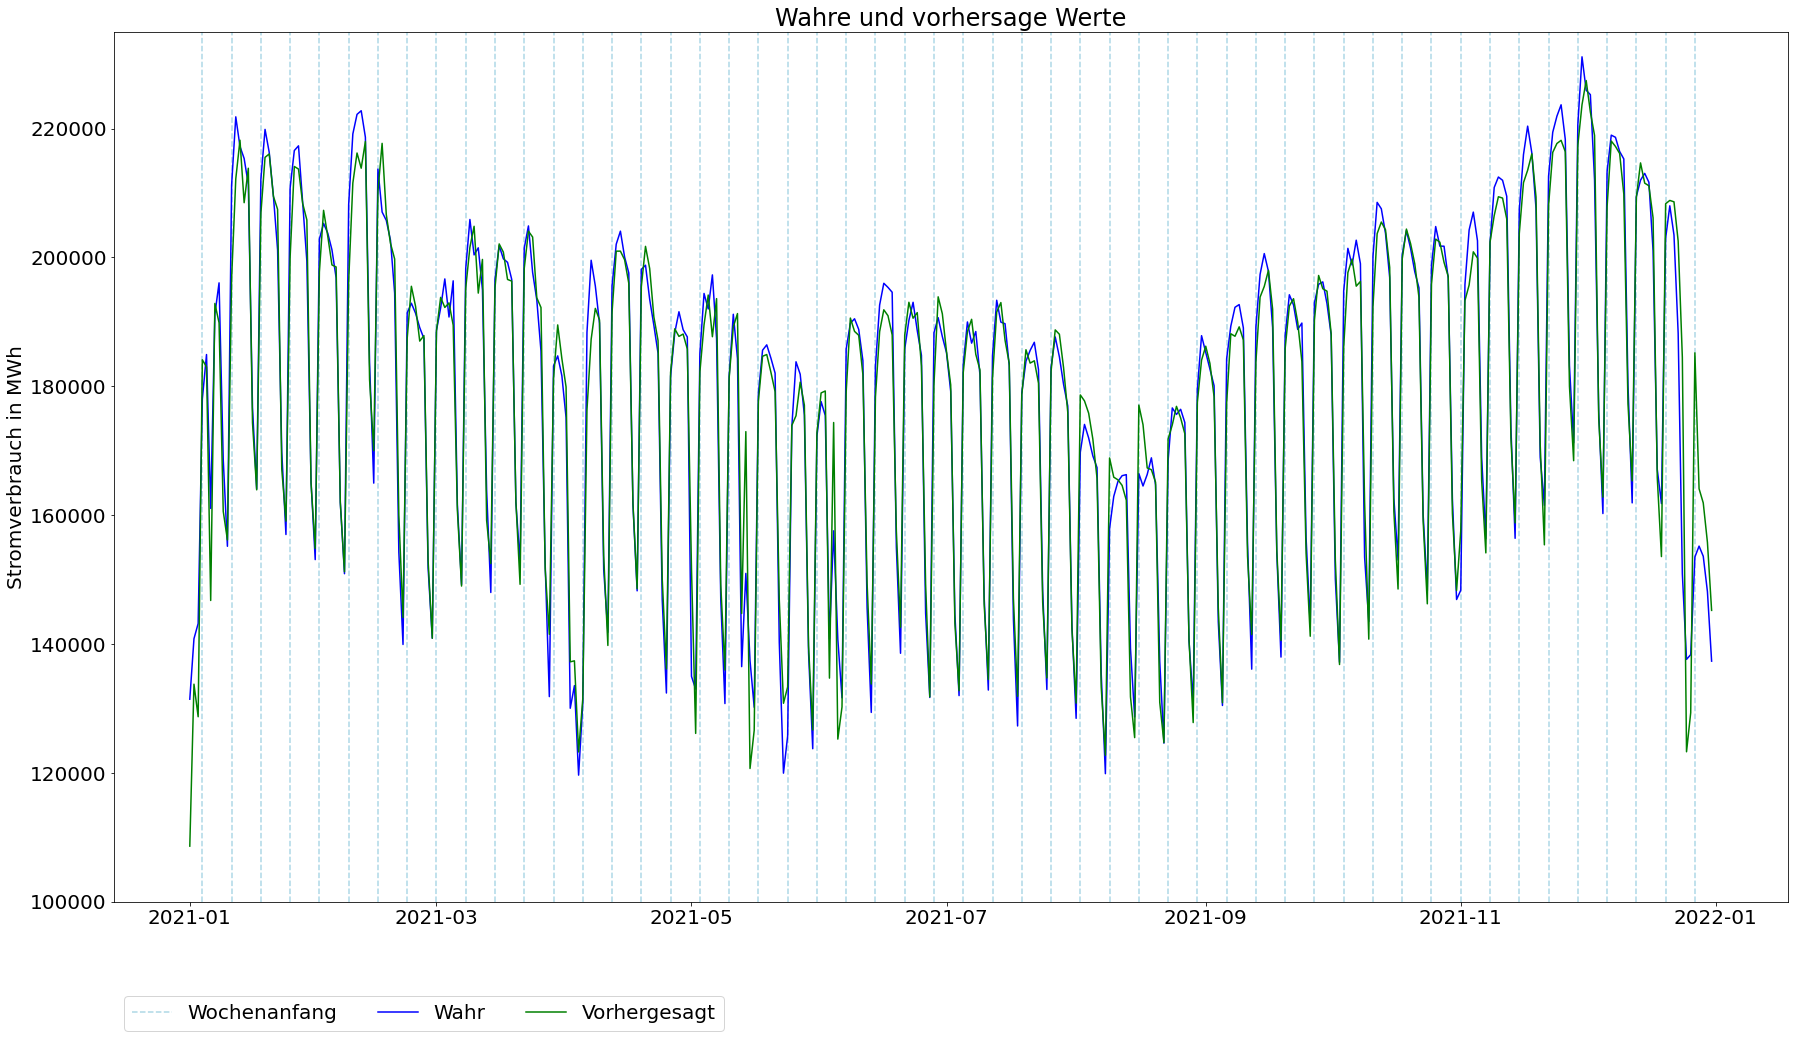

In [4]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds)

## <font size="6">ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur, Tagesstunden]</font><a class="anchor" id="4-02b-arbeitstagtemperaturtagesstunden"></a>

<font size="5">Durch Hinzuziehen der Anzahl an Tagesstunden verschlechtert sich das Modell allerdings. Der MAPE steigt auf 2,26%. Die Log-Likelihood bleibt zwar gleich, aber das AIC steigt dementsprechend auf -8.662. Das Modell scheint also keine Informationen aus den Tagesstunden ziehen zu können. Der Koeffizient liegt leicht über dem Signifikanzniveau von 5%.<font>

In [9]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4342.939
Date:                           Thu, 03 Feb 2022   AIC                          -8661.878
Time:                                   13:47:03   BIC                          -8591.719
Sample:                               01-01-2015   HQIC                         -8636.436
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
arbeitstag       0.3027      0.002    124.670      0.000       0.298       0.307
temperatur      -0.0528      0.014   

      Vorhersage
R2          0.95
MAE       3828.0
MSE   31729626.0
RMSE      5633.0
                
MAPE      2.26 %


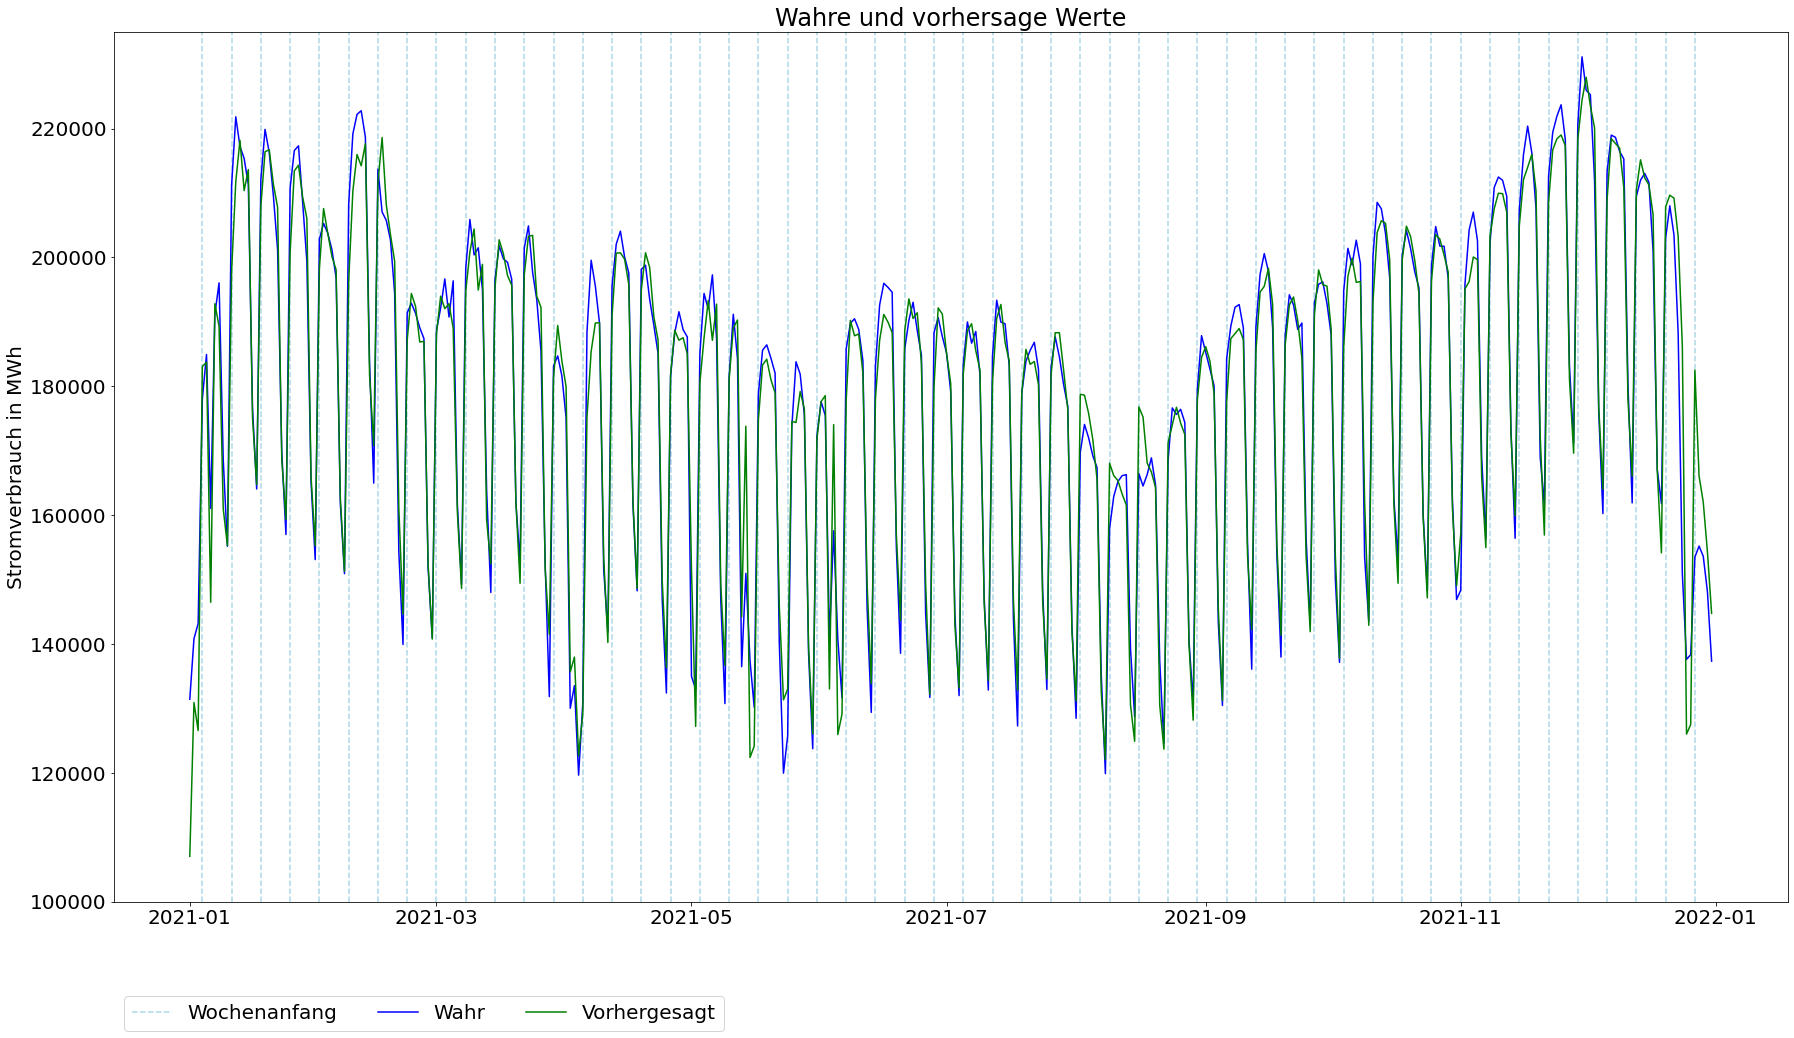

In [10]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds)

# <font size="7">Modifikation der Ordnungen</font><a class="anchor" id="4-02b-modifikation"></a>

<font size="5">Die Tagesstunden scheinen dem Modell kein Potenzial für Generalisierungen zu bilden. Es werden einige Ordnung testweise ausprobiert, jeweils mit und ohne Tagesstunden. Ziel ist es, zu ermitteln, ob die Tagesstunden bei anderem Parametern eine Rolle spielen könnten.<font>

## <font size="6">ARIMA(3,0,3)(3,0,3)7</font><a class="anchor" id="4-02b-ARIMA(3,0,3)(3,0,3)7"></a>

<font size="5">Beim ARIMA(3,0,3)(3,0,3)7 werden die Ordnungen jeweils um ein Lag erweitert. Das zusätzliche Lag in jedem Modul führt zu keiner wirklichen Verbesserung. MAPE und Log-Likelihood sind ähnlich, das AIC ist aufgrund der höheren Komplexität allerdings etwas höher. Das Modell erreicht ohne Tagesstunden allerdings leicht bessere Metriken.<font>

### <font size="5">ARIMA(3,0,3)(3,0,3)7 [Arbeitstag, Temperatur, Tagesstunden]</font> 

In [15]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (3, 0, 3) #p, d, q
seasonal_order = (3, 0, 3, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 7)   Log Likelihood                4333.237
Date:                           Thu, 03 Feb 2022   AIC                          -8634.474
Time:                                   14:04:12   BIC                          -8540.928
Sample:                               01-01-2015   HQIC                         -8600.551
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
arbeitstag       0.2955      0.002    129.938      0.000       0.291       0.300
temperatur      -0.0208      0.014   

In [16]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.95
MAE       3820.0
MSE   31552929.0
RMSE      5617.0
                
MAPE      2.25 %


### <font size="5">ARIMA(3,0,3)(3,0,3)7 [Arbeitstag, Temperatur]</font> 

In [17]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (3, 0, 3) #p, d, q
seasonal_order = (3, 0, 3, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 7)   Log Likelihood                4345.640
Date:                           Thu, 03 Feb 2022   AIC                          -8661.280
Time:                                   14:04:44   BIC                          -8573.581
Sample:                               01-01-2015   HQIC                         -8629.477
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2977      0.002    131.174      0.000       0.293       0.302
temperatur    -0.0206      0.014     -1.482

In [18]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.96
MAE       3777.0
MSE   30993539.0
RMSE      5567.0
                
MAPE      2.23 %


## <font size="6">ARIMA(4,0,4)(4,0,4)7</font>

<font size="5">Beim ARIMA(4,0,4)(4,0,4)7 werden die Ordnungen jeweils um zwei Lags erweitert. Wie auch beim endogenen Modell führen die zusätzlichen Lags nicht zu einer Verbesserung, stattdessen setzt eine Überanpassung ein. Bei den Modellen mit und ohne Tagesstunden lassen sich kaum Unterschiede feststellen.<font>

### <font size="5">ARIMA(4,0,4)(4,0,4)7 [Arbeitstag, Temperatur, Tagesstunden]</font> 

In [20]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (4, 0, 4) #p, d, q
seasonal_order = (4, 0, 4, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(4, 0, 4)x(4, 0, 4, 7)   Log Likelihood                4360.016
Date:                           Thu, 03 Feb 2022   AIC                          -8680.032
Time:                                   14:07:56   BIC                          -8563.100
Sample:                               01-01-2015   HQIC                         -8637.629
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
arbeitstag       0.2987      0.002    127.551      0.000       0.294       0.303
temperatur      -0.0500      0.014   

In [21]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.96
MAE       3796.0
MSE   30543780.0
RMSE      5527.0
                
MAPE      2.23 %


### <font size="5">ARIMA(4,0,4)(4,0,4)7 [Arbeitstag, Temperatur]</font> 

In [22]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (4, 0, 4) #p, d, q
seasonal_order = (4, 0, 4, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(4, 0, 4)x(4, 0, 4, 7)   Log Likelihood                4349.537
Date:                           Thu, 03 Feb 2022   AIC                          -8661.074
Time:                                   14:08:53   BIC                          -8549.989
Sample:                               01-01-2015   HQIC                         -8620.791
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2886      0.002    129.499      0.000       0.284       0.293
temperatur    -0.0621      0.014     -4.420

In [23]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.96
MAE       3828.0
MSE   30602807.0
RMSE      5532.0
                
MAPE      2.24 %


## <font size="6">ARIMA([1,2,4],0,2)(2,0,2)7</font><a class="anchor" id="4-02b-ARIMA([1,2,4],0,2)(2,0,2)7"></a>

<font size="5">Wenn nur die nach der ACF/PACF stark korrelierten Lags in das Modell einbezogen werden zeigt sich ein ähnliches Bild. Das Modell ohne Tagesstunden schneidet bei allen drei Metriken etwas besser ab als mit Tagesstunden.<font>

### <font size="5">ARIMA([1,2,4],0,2)(2,0,2)7 [Arbeitstag, Temperatur, Tagesstunden]</font> 

In [24]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = ([1,2,4], 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                         SARIMAX Results                                         
Dep. Variable:                                 verbrauch   No. Observations:                 2557
Model:             SARIMAX([1, 2, 4], 0, 2)x(2, 0, 2, 7)   Log Likelihood                4321.181
Date:                                   Thu, 03 Feb 2022   AIC                          -8616.361
Time:                                           14:09:58   BIC                          -8540.356
Sample:                                       01-01-2015   HQIC                         -8588.799
                                            - 12-31-2021                                         
Covariance Type:                                     opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
arbeitstag       0.2908      0.002    128.262      0.0

In [25]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.95
MAE       3849.0
MSE   32288209.0
RMSE      5682.0
                
MAPE      2.27 %


### <font size="5">ARIMA([1,2,4],0,2)(2,0,2)7 [Arbeitstag, Temperatur]</font> 

In [26]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = ([1,2,4], 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                         SARIMAX Results                                         
Dep. Variable:                                 verbrauch   No. Observations:                 2557
Model:             SARIMAX([1, 2, 4], 0, 2)x(2, 0, 2, 7)   Log Likelihood                4327.745
Date:                                   Thu, 03 Feb 2022   AIC                          -8631.490
Time:                                           14:10:08   BIC                          -8561.331
Sample:                                       01-01-2015   HQIC                         -8606.048
                                            - 12-31-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2958      0.002    130.238      0.000    

In [27]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.96
MAE       3749.0
MSE   31189905.0
RMSE      5585.0
                
MAPE      2.21 %


## <font size="6">ARIMA(1,0,1)(1,0,1)7</font>

<font size="5">Beim ARIMA(1,0,1)(1,0,1)7 werden die Ordnungen jeweils um ein Lag gekürzt. Dadurch verschlechtert sich die Genauigkeit der Vorhersagen allerdings stark. Der MAPE fällt auf über 2,3% ab, auch Log-Likelihood und AIC verschlechtern sind. Allerdings zeigt sich auch hier, dass das Modell nicht auf die Tagesstunden angewiesen scheint, da das Modell ohne Tagesstunden etwas besser abschneidet.<font>

### <font size="5">ARIMA(1,0,1)(1,0,1)7 [Arbeitstag, Temperatur, Tagesstunden]</font> 

In [5]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (1, 0, 1) #p, d, q
seasonal_order = (1, 0, 1, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                4220.253
Date:                           Fri, 04 Feb 2022   AIC                          -8424.505
Time:                                   12:32:56   BIC                          -8377.732
Sample:                               01-01-2015   HQIC                         -8407.544
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
arbeitstag       0.3077      0.002    127.414      0.000       0.303       0.312
temperatur      -0.0215      0.014   

In [6]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.95
MAE       4055.0
MSE   34528008.0
RMSE      5876.0
                
MAPE      2.38 %


### <font size="5">ARIMA(1,0,1)(1,0,1)7 [Arbeitstag, Temperatur]</font> 

In [7]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (1, 0, 1) #p, d, q
seasonal_order = (1, 0, 1, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag","temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                4235.412
Date:                           Fri, 04 Feb 2022   AIC                          -8425.824
Time:                                   12:33:00   BIC                          -8605.898
Sample:                               01-01-2015   HQIC                         -8631.983
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2978      0.002    136.299      0.000       0.293       0.302
temperatur    -0.0603      0.014     -4.357

In [8]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, plot=False)

      Vorhersage
R2          0.95
MAE       3925.0
MSE   33414892.0
RMSE      5755.0
                
MAPE      2.31 %


# <font size="7">Ergebnis</font><a class="anchor" id="4-02b-ergebnis"></a>

<font size="5">Es zeigt sich, dass sich das ARIMA(2,0,2)(2,0,2)7 durch den Indikator für Arbeitstage und die Temperatur verbessern lässt. Die Tagesstunden scheinen keinen zusätzlichen Informationsgehalt zu bieten und verschlechtern das Modell eher. Eine andere Ordnung wird nicht gewählt.<font>

## <font size="6">ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur]</font>

<font size="5">Das ARIMA(2,0,2)(2,0,2)7 [Arbeitstag, Temperatur] kann die Zeitreihe sehr viel besser abbilden als das endogene Modell. Stellenweise ist das Modell jedoch leicht nach unten verzerrt. Außerdem gibt es an bestimmten Stellen sehr große Abweichungen, wie im Residualplot erkennbar ist.</font>

In [45]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, exog=exog_train[["arbeitstag", "temperatur"]], order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, exog=exog[["arbeitstag", "temperatur"]], order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                4352.812
Date:                           Thu, 03 Feb 2022   AIC                          -8683.624
Time:                                   14:49:32   BIC                          -8619.312
Sample:                               01-01-2015   HQIC                         -8660.303
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
arbeitstag     0.2967      0.002    129.917      0.000       0.292       0.301
temperatur    -0.0575      0.014     -4.138

      Vorhersage
R2          0.96
MAE       3777.0
MSE   31046773.0
RMSE      5572.0
                
MAPE      2.22 %


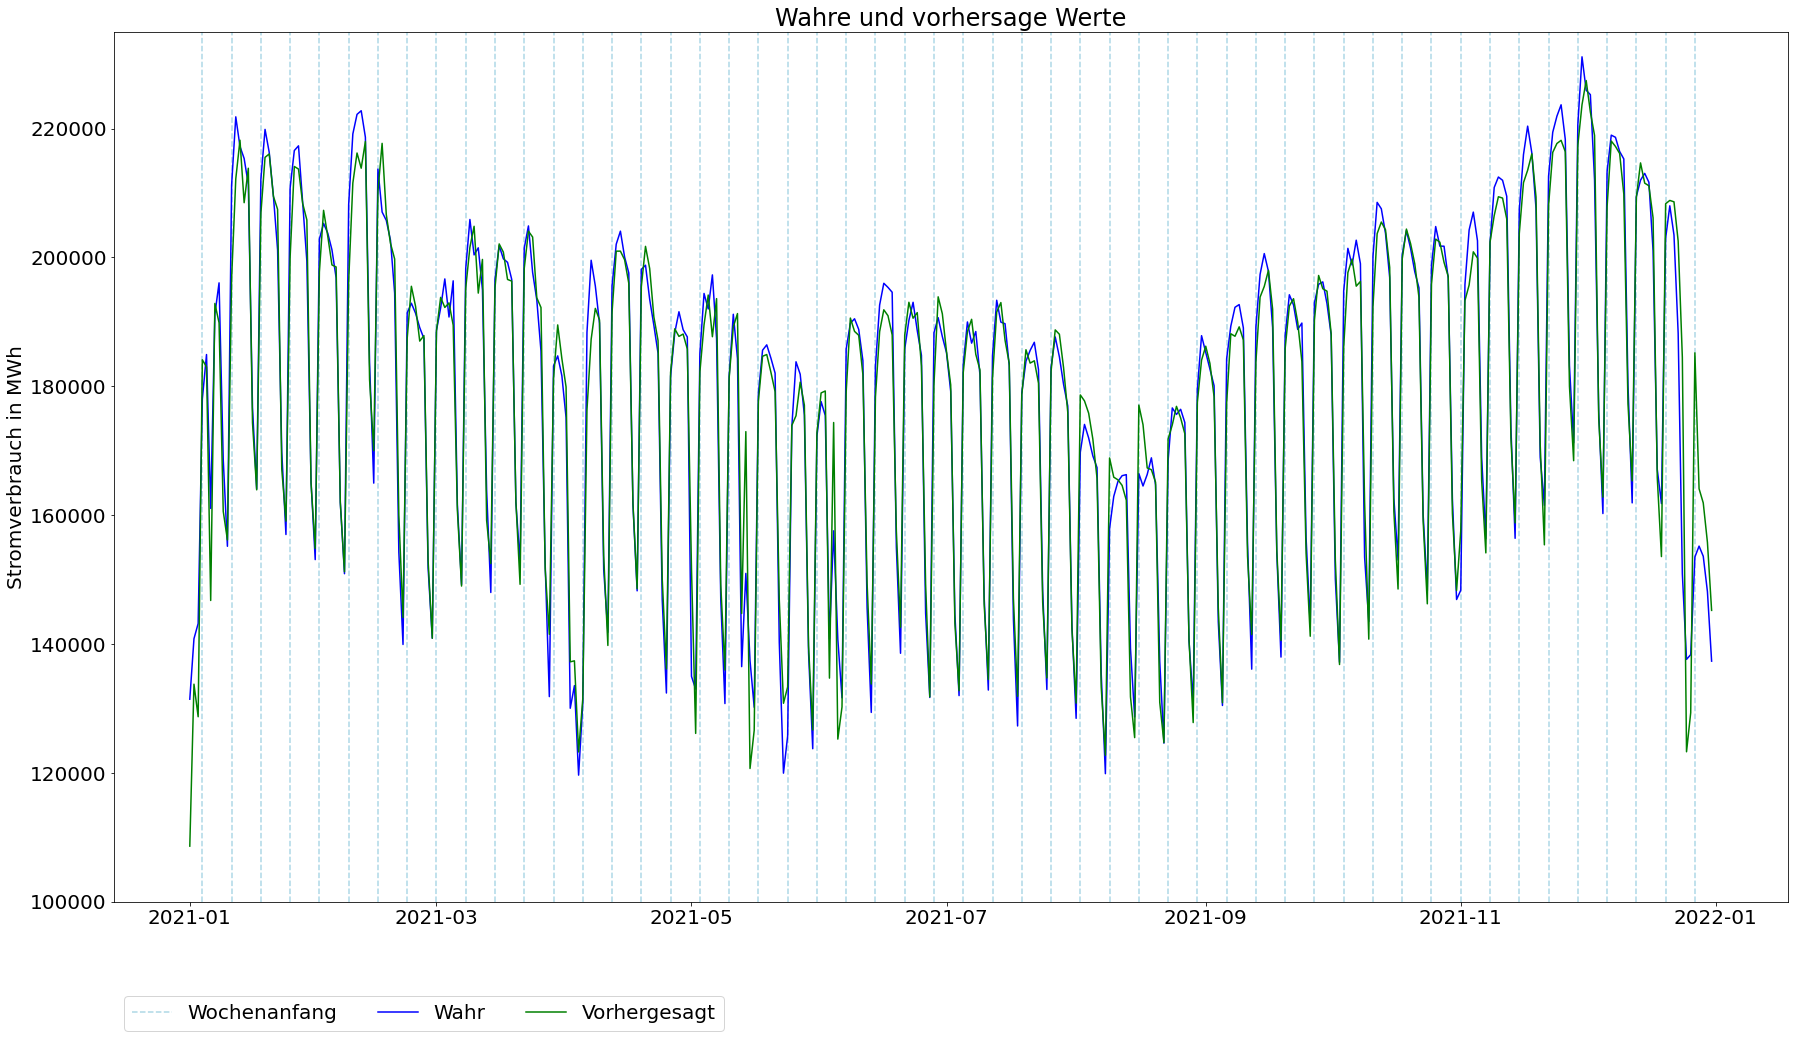

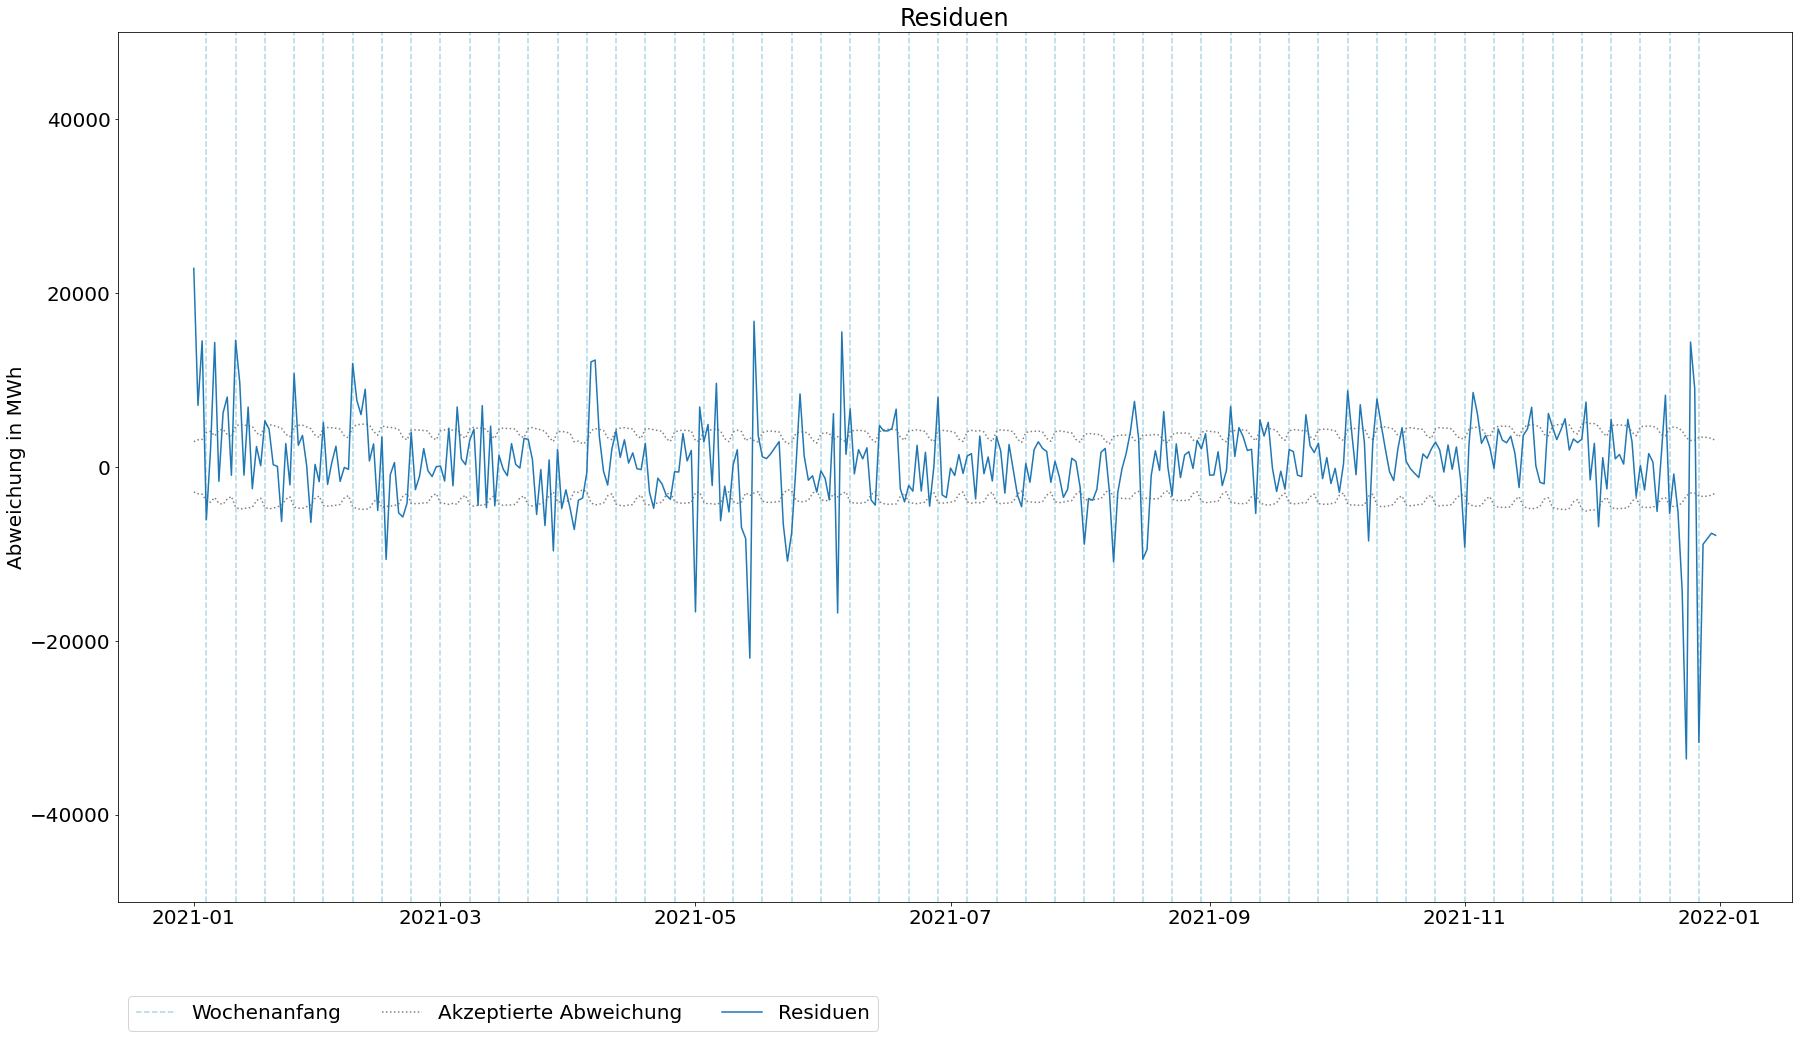

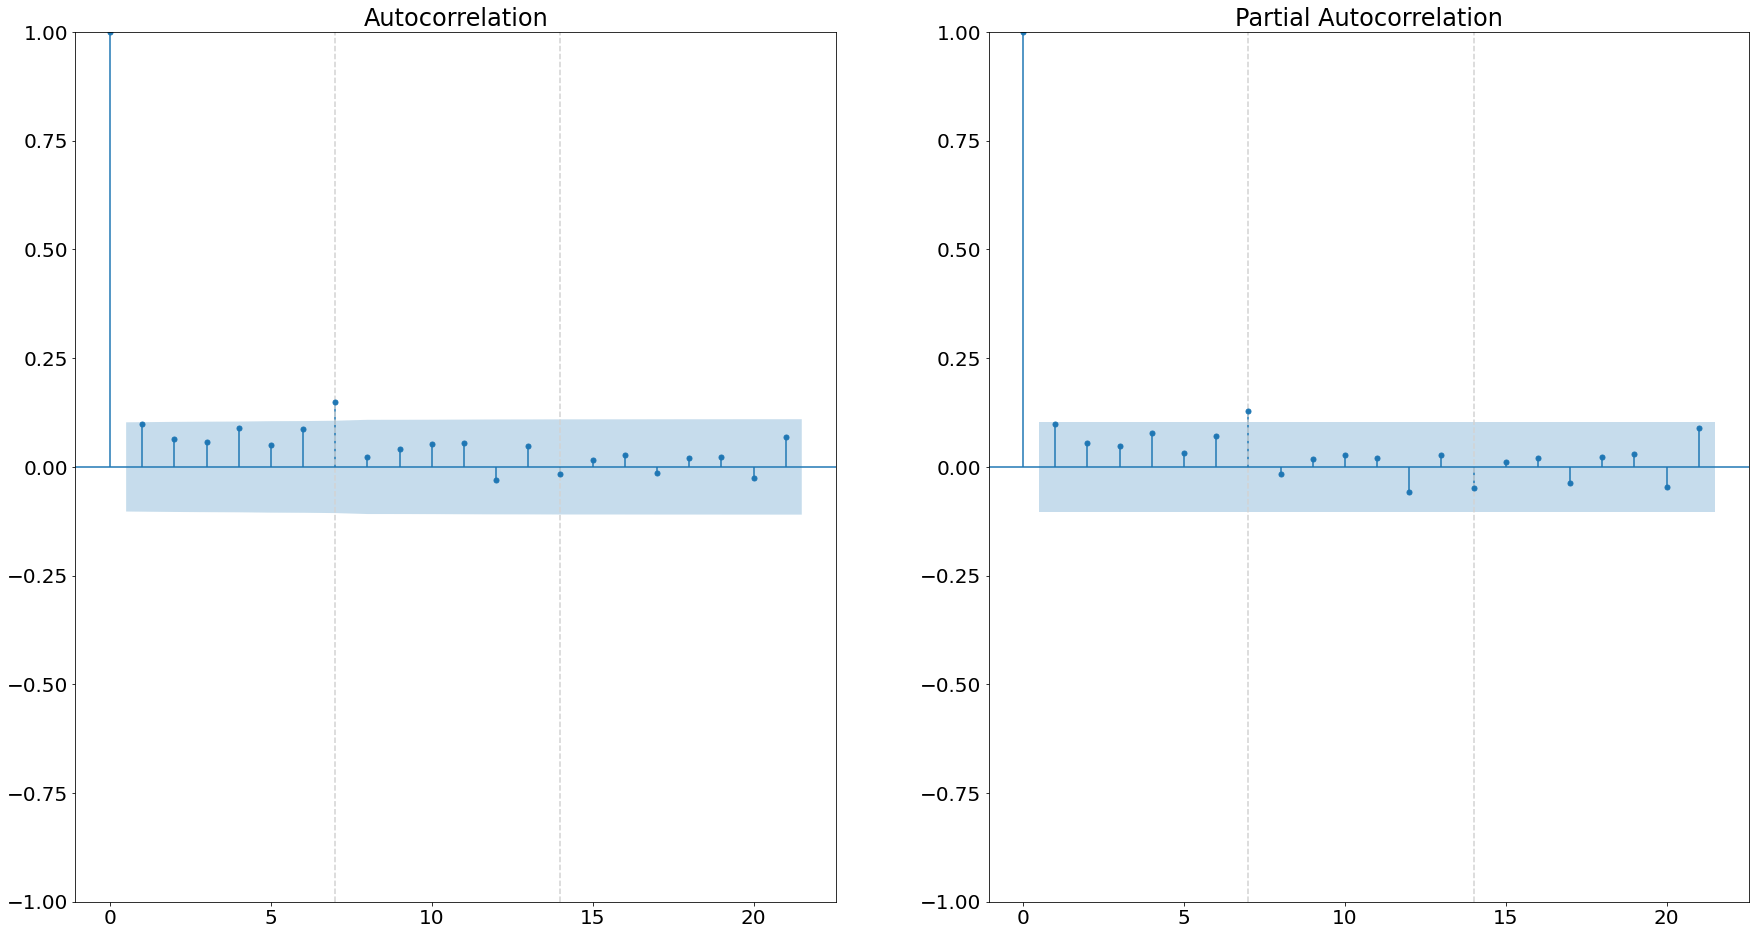

In [46]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds, True, True, True, True)